In [1]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [2]:
X.shape

(60, 3)

In [3]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
X2D=pca.fit_transform(X)

In [4]:
X2D.shape

(60, 2)

In [5]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

# Explained Variance Ratio

In [6]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [7]:
1-pca.explained_variance_ratio_.sum()

np.float64(0.09028309326742057)

In [8]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784',as_frame=False,parser="auto")
X_train,y_train=mnist.data[:60_000],mnist.target[:60_000]
X_test,y_test=mnist.data[60_000:],mnist.target[60_000:]

pca=PCA()
pca.fit(X_train)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1

In [9]:
pca.explained_variance_ratio_[:10]

array([0.09704664, 0.07095924, 0.06169089, 0.05389419, 0.04868797,
       0.04312231, 0.0327193 , 0.02883895, 0.02762029, 0.02357001])

In [10]:
pca=PCA(n_components=0.95)
X_reduced=pca.fit_transform(X_train)

In [11]:
X_test_reduced=pca.transform(X_test)

In [12]:
pca.n_components_

np.int64(154)

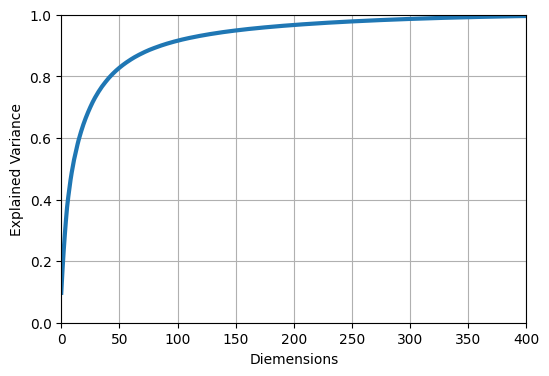

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(cumsum,linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel('Diemensions')
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

In [14]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [15]:

print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [16]:

rnd_search.best_estimator_.fit(X_train, y_train)
rnd_search.best_estimator_.score(X_test, y_test)

0.9563

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [18]:

grid_search.best_params_

{'pca__n_components': np.int64(60)}

In [19]:
grid_search.best_estimator_.fit(X_train,y_train)
grid_search.best_estimator_.fit(X_test,y_test)

Pipeline(steps=[('pca', PCA(n_components=np.int64(60), random_state=42)),
                ('sgdclassifier', SGDClassifier())])

# PCA for Compression

In [20]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)



In [21]:

X_recovered = pca.inverse_transform(X_reduced)


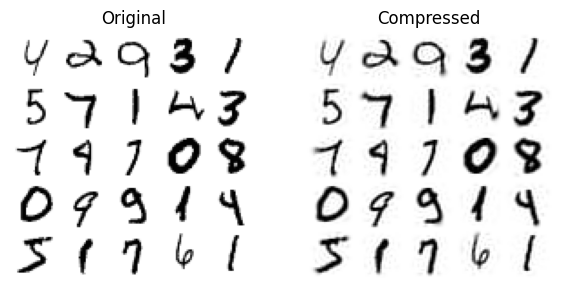

In [22]:
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")


In [23]:


rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)


In [24]:

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

# LLE

In [25]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)


In [26]:

from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [27]:
from sklearn.manifold import Isomap

isomap=Isomap(n_components=2)
Xreduced_isomap=isomap.fit_transform(X_swiss)

In [28]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,init="random",learning_rate="auto",
          random_state=42)
X_reduced_tsne=tsne.fit_transform(X_swiss)

In [29]:
X_sample,y_sample=X_train[:5000],y_train[:5000]

In [30]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,init="random",learning_rate="auto",
          random_state=42)
%time X_reduced=tsne.fit_transform(X_sample)

CPU times: user 59.6 s, sys: 75 ms, total: 59.7 s
Wall time: 1min


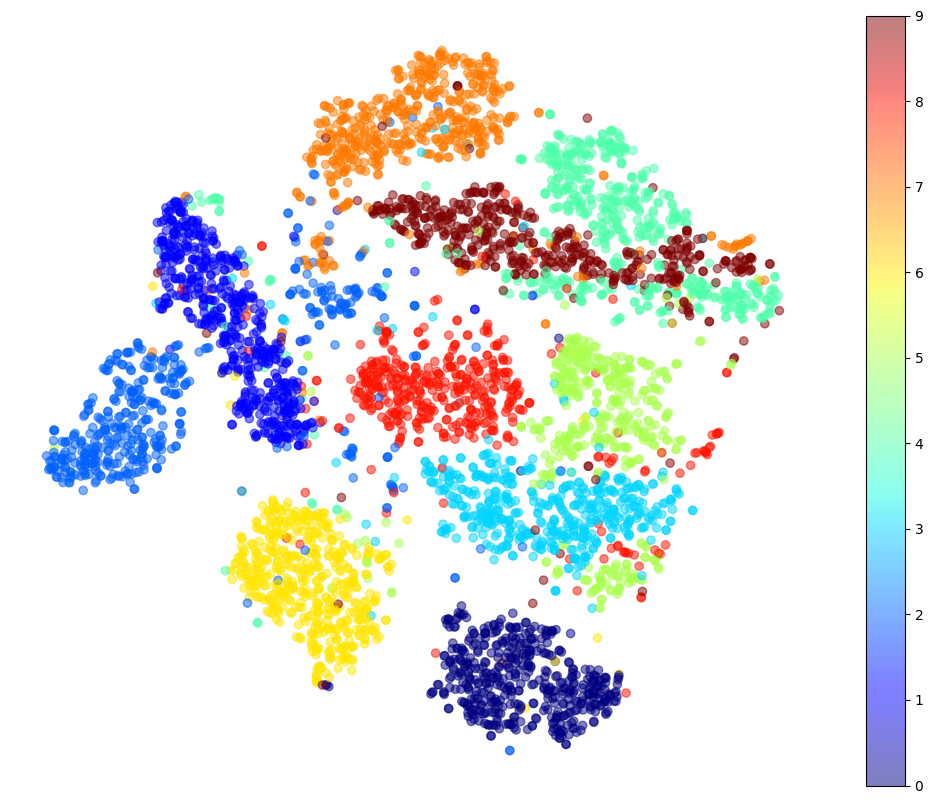

In [31]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:,0],X_reduced[:,1],
            c=y_sample.astype(np.int8),cmap="jet",alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

# Tekrar

In [32]:
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
X_reduced=pca.fit_transform(X_sample)

In [33]:
pca.explained_variance_ratio_

array([0.09867566, 0.07404546])

In [34]:
1- pca.explained_variance_ratio_.sum()

np.float64(0.8272788794864057)

# Choosing the right number of Dimensions

In [35]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
mnist = fetch_openml('mnist_784', as_frame= False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test= mnist.data[60_000:], mnist.target[60_000:]

In [36]:
X_train.shape

(60000, 784)

In [37]:
pca= PCA()
pca.fit(X_train)
pca.explained_variance_ratio_

array([9.70466436e-02, 7.09592406e-02, 6.16908876e-02, 5.38941949e-02,
       4.86879702e-02, 4.31223132e-02, 3.27192995e-02, 2.88389545e-02,
       2.76202940e-02, 2.35700055e-02, 2.10918962e-02, 2.02299108e-02,
       1.71581820e-02, 1.69211143e-02, 1.57864128e-02, 1.48295261e-02,
       1.32456095e-02, 1.27689737e-02, 1.18726294e-02, 1.15268370e-02,
       1.06616621e-02, 1.00671337e-02, 9.53573327e-03, 9.12543746e-03,
       8.83404692e-03, 8.39319141e-03, 8.12578809e-03, 7.86366084e-03,
       7.44733102e-03, 6.90859128e-03, 6.58093773e-03, 6.48147870e-03,
       6.02615030e-03, 5.86582188e-03, 5.70021474e-03, 5.43627771e-03,
       5.05786416e-03, 4.87858604e-03, 4.81429342e-03, 4.72266326e-03,
       4.56746921e-03, 4.44836012e-03, 4.18501329e-03, 3.98215339e-03,
       3.84974607e-03, 3.75103387e-03, 3.62008852e-03, 3.51591277e-03,
       3.40058205e-03, 3.21874467e-03, 3.19017051e-03, 3.12804939e-03,
       2.95982668e-03, 2.88954600e-03, 2.84130398e-03, 2.71435811e-03,
      

In [38]:
pca= PCA()
pca.fit(X_train)
cumsuum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1

In [39]:
cumsum


array([0.09704664, 0.16800588, 0.22969677, 0.28359097, 0.33227894,
       0.37540125, 0.40812055, 0.4369595 , 0.4645798 , 0.4881498 ,
       0.5092417 , 0.52947161, 0.54662979, 0.56355091, 0.57933732,
       0.59416685, 0.60741246, 0.62018143, 0.63205406, 0.6435809 ,
       0.65424256, 0.66430969, 0.67384542, 0.68297086, 0.69180491,
       0.7001981 , 0.70832389, 0.71618755, 0.72363488, 0.73054347,
       0.73712441, 0.74360589, 0.74963204, 0.75549786, 0.76119807,
       0.76663435, 0.77169222, 0.7765708 , 0.7813851 , 0.78610776,
       0.79067523, 0.79512359, 0.7993086 , 0.80329076, 0.8071405 ,
       0.81089154, 0.81451162, 0.81802754, 0.82142812, 0.82464686,
       0.82783703, 0.83096508, 0.83392491, 0.83681446, 0.83965576,
       0.84237012, 0.84506533, 0.84765006, 0.85018776, 0.85263557,
       0.85504063, 0.85743326, 0.85973735, 0.86195267, 0.86408988,
       0.86616213, 0.86819256, 0.87016038, 0.87208891, 0.87397523,
       0.875845  , 0.87765583, 0.87943146, 0.88118044, 0.88283

In [40]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

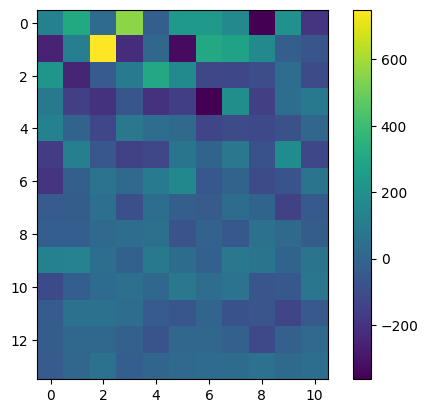

In [41]:
plt.imshow(X_reduced[0].reshape(14,11))
plt.colorbar();

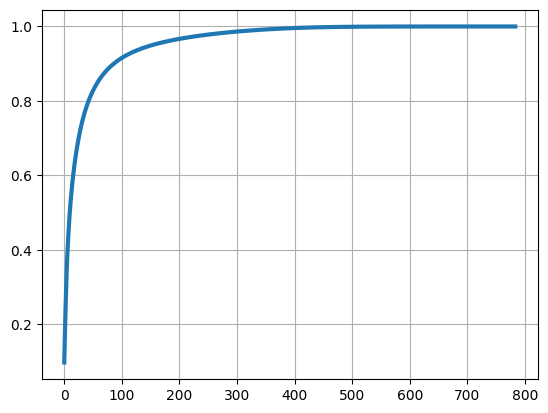

In [42]:
plt.plot(cumsum,linewidth=3)
plt.grid();

In [43]:
from sklearn.decomposition import IncrementalPCA

n_batches=100
inc_pca=IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced= inc_pca.transform(X_train)


In [44]:
from sklearn.model_selection import RandomizedSearchCV
from  sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

clf=make_pipeline(PCA(random_state=42),RandomForestClassifier(random_state=42))

params={
    "pca__n_components":np.arange(10,80),
    "randomforestclassifier__n_estimators":np.arange(50,500)
}

search_cv=RandomizedSearchCV(clf,params,n_iter=10,cv=3,random_state=42)
search_cv.fit(X_train[:1000],y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

# LLE -> Locally Linear Embedding

In [45]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t=make_swiss_roll(n_samples=1000,noise=0.2,random_state=42)
lle=LocallyLinearEmbedding(n_components=2,n_neighbors=10,random_state=42)
X_reduced = lle.fit_transform(X_swiss)

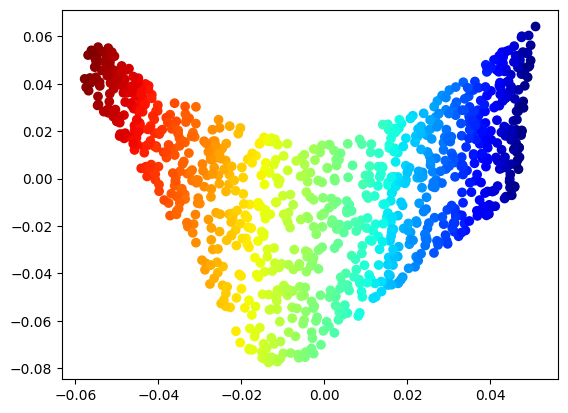

In [46]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=t, cmap= "jet");

In [47]:
from sklearn.manifold import TSNE
tsne= TSNE(n_components=2, random_state=42)
X_reduced=tsne.fit_transform(X_swiss)

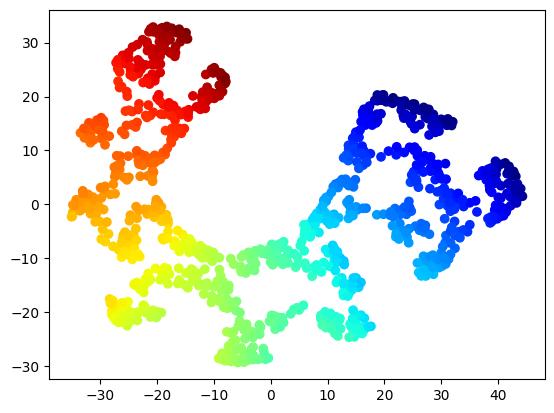

In [48]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=t, cmap="jet")